# Reliability test based on the Yang Baxter equation


To run the experiment over real backends set secure_mode=False. Otherwhise results will be recovered from past experiments. 

In [1]:
secure_mode=True

In [2]:
%matplotlib inline
# Importing standard Qiskit libraries and configuring account
from qiskit import *
from qiskit.compiler import transpile, assemble
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from qiskit.circuit import Parameter
import numpy as np
import sympy as sy

from qiskit.circuit import Gate

IBMQ.load_account() # Load account from disk
IBMQ.providers()
provider=IBMQ.get_provider(hub='ibm-q-csic')
pi=np.pi

In this notebook we will develop a reliability test based on the Yang Baxter equation


<img src='test.png'>

# Gates

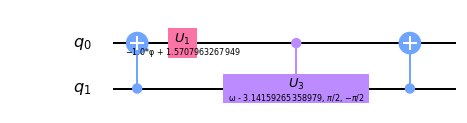

In [3]:
omega=Parameter('ω')
phi=Parameter('φ')



#crate gate 
Rb = QuantumCircuit(2, name='$R^b$')

Rb.cx(1,0)
Rb.u1(-phi+pi/2,0)
Rb.cu3(omega-pi, pi/2, -pi/2, 0,1)
Rb.cx(1,0)


# Draw the circuit
Rb.draw(output='mpl')

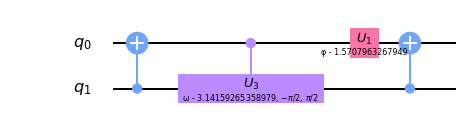

In [4]:
#crate gate 
Rbdagger = QuantumCircuit(2, name='$R^{b\dagger}$')

Rbdagger.cx(1,0)

Rbdagger.cu3(omega-pi, -pi/2, pi/2, 0,1)
Rbdagger.u1(phi-pi/2,0)
Rbdagger.cx(1,0)


# Draw the circuit
Rbdagger.draw(output='mpl')

# Circuits

The test is based on the measurement of the output when the imput is any of the elements of  the computational basis 

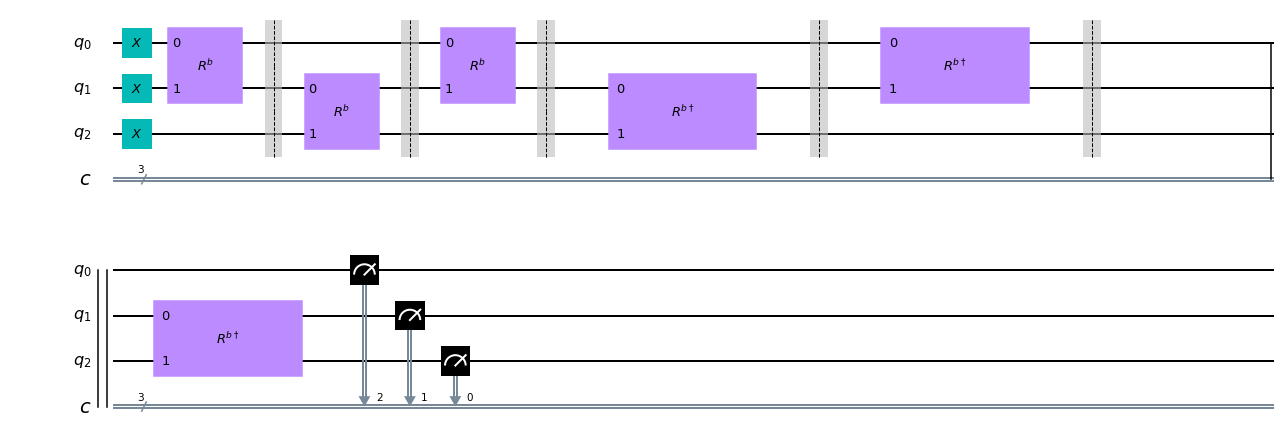

In [5]:
phis=[Parameter('φ_'+str(i)) for i in range(1,4)]
omegas=[Parameter('ω_'+str(i)) for i in range(1,4)]

YBs=[Rb.to_gate({phi:phis[i],omega:omegas[i]}) for i in range(0,3)]
YBsdagger=[Rbdagger.to_gate({phi:phis[i],omega:omegas[i]}) for i in range(0,3)]


testCircuit={}
for q0 in range(2):
    for q1 in range(2):
        for q2 in range(2):
            name=str(q0)+str(q1)+str(q2)
            circ=QuantumCircuit(3,3, name='Test '+name)
            if q0==1:
              circ.x(0)  
            if q1==1:
              circ.x(1)  
            if q2==1:
              circ.x(2)
            circ.append(YBs[0], [0,1])
            circ.barrier()
            circ.append(YBs[1], [1,2])
            circ.barrier()
            circ.append(YBs[2], [0,1])
            circ.barrier()
            circ.append(YBsdagger[0], [1,2])
            circ.barrier()
            circ.append(YBsdagger[1], [0,1])
            circ.barrier()
            circ.append(YBsdagger[2], [1,2])


            circ.measure([0,1,2],[2,1,0])
            testCircuit.update({name:circ})

testCircuitlist=[]
for i in testCircuit:
    testCircuitlist.append( testCircuit[i])

# Map the quantum measurement to the classical bits
circ.draw(output='mpl')



## This particular example is such that  $\omega_{x}=\pi$ and $\omega_{xy}=\pi/2$ for $\theta=\pi/4$

In [6]:
import math
def realAngles(x1,x2,theta,phis,omegas):
        """
         INPUT: 'x1'  --double; x parameter
                'x2' --double; y parameter
                'theta' --double; theta parameter
         OUTPUT: --{Parameter:double}; Values of the parameters for the 
                    given inputs
         EXAMPLES:
        """
        h=[x1,x1+x2,x2]
        subsprim={}
        for i in range(3):
            subsprim.update({phis[i]:np.angle(complex(np.sinh(h[i])*np.cos(theta),
                                            np.cosh(h[i])*np.sin(theta))) ,
             omegas[i]:2*np.angle(complex(np.sinh(h[i]),np.sin(theta))) }
            )
        return subsprim

In [7]:
### obtain x,y from \omega_x, omega_{xy} and theta

def realParameter(omegax,omegaxy,theta):
    a=np.tan(omegax/2)
    b=np.tan(omegaxy/2)

    x=np.arcsinh(np.sin(theta)/a)
    y=np.arcsinh(np.sin(theta)/b)
    y=y-x
    return x,y,theta

to run in secure mode

In [8]:
import pickle
import matplotlib.pyplot as plt
import numpy as np

if secure_mode:
    file="experiments/Consistency_braided_test_Full_7_6_2020_23_0.pkl"
    pickle_off = open(file,"rb")
    data = pickle.load(pickle_off)
    pickle_off.close()

qbits={
 'ibmq_ourense':'[0,1,2]',
 'ibmqx2':'[2,3,4]',
 'ibmq_johannesburg_1':'[11,12,13]',
 'ibmq_johannesburg':'[5,0,1]',
 'qasm_simulator':''   
}

# Simulation

In [9]:
job={}
legend=["|"+i+">" for i in testCircuit]
color=['#648fff', '#dc267f', '#785ef0', '#ffb000', '#fe6100','#4D0EFA', 'B70404', '#008404']
x1,x2,theta=realParameter(pi,pi/2,pi/4)
subsprim=realAngles(x1,x2,theta,phis,omegas)
tit=' x='+"{:.3f}".format(x1)+', y='+"{:.3f}".format(x2)+', $\\theta=\pi/2$'
qbits={
 'ibmq_ourense':'[0,1,2]',
 'ibmqx2':'[2,3,4]',
 'ibmq_johannesburg_1':'[11,12,13]',
 'ibmq_johannesburg':'[5,0,1]',
 'qasm_simulator':''   
}


In [10]:
# Real Backend
key='ibmqx2'
backend = provider.get_backend(key)
initial_layout=[2,3,4]
compiled_circuits = transpile(testCircuitlist, backend=backend, initial_layout=initial_layout,optimization_level=3)


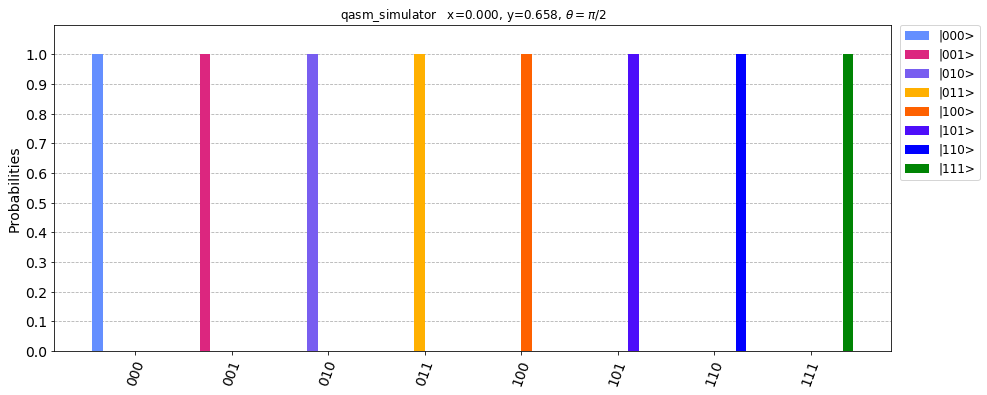

In [11]:
key='qasm_simulator'
backend = Aer.get_backend('qasm_simulator')

job.update({key:execute(compiled_circuits,
              backend=backend,
              parameter_binds=[subsprim],shots=8192)})


p=plot_histogram([job[key].result().get_counts(i) for i in range(8)],figsize=(15,6),color=color,legend=legend,title=key+' '+qbits[key]+' '+tit,bar_labels=False)
p.axes[0].set_yticks([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])
p.axes[0].set_ylim(top=1.1)
p

# IBMX2

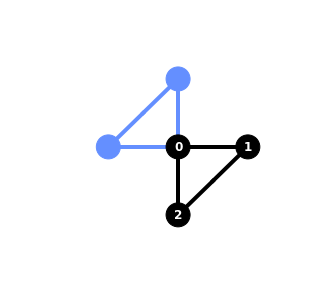

In [12]:
key='ibmqx2'
backend = provider.get_backend(key)
initial_layout=[2,3,4]
compiled_circuits = transpile(testCircuitlist, backend=backend, initial_layout=initial_layout,optimization_level=3)

plot_circuit_layout(compiled_circuits[0], backend)

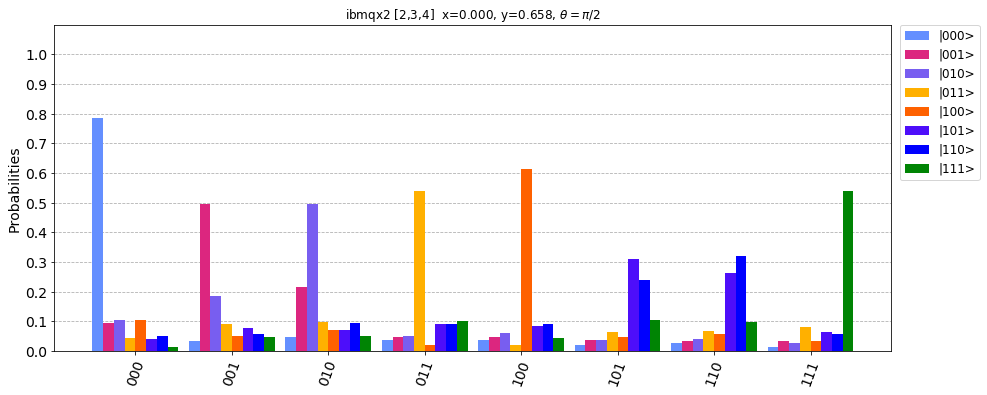

In [13]:
if secure_mode:
    job.update({key:data[key]})
    p=plot_histogram([job[key][i] for i in range(8)],figsize=(15,6),color=color,legend=legend,title=key+' '+qbits[key]+' '+tit,bar_labels=False)
else:
    job.update({key:execute(compiled_circuits,
                backend=backend,
                parameter_binds=[subsprim],shots=8192)})
    p=plot_histogram([job[key].result().get_counts(i) for i in range(8)],figsize=(15,6),color=color,legend=legend,title=key+' '+qbits[key]+' '+tit,bar_labels=False)

p.axes[0].set_yticks([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])
p.axes[0].set_ylim(top=1.1)
p

# ibmq_ourense

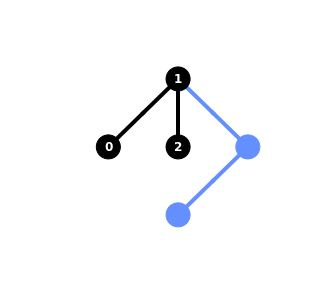

In [14]:
key='ibmq_ourense'
backend = provider.get_backend(key)
initial_layout=[0,1,2]
compiled_circuits = transpile(testCircuitlist, backend=backend, initial_layout=initial_layout,optimization_level=3)

plot_circuit_layout(compiled_circuits[0], backend)

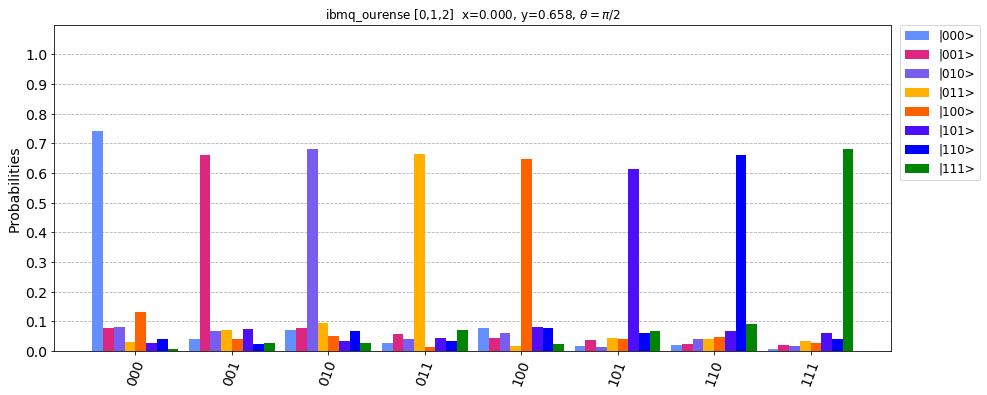

In [15]:
if secure_mode:
    job.update({key:data[key]})
    p=plot_histogram([job[key][i] for i in range(8)],figsize=(15,6),color=color,legend=legend,title=key+' '+qbits[key]+' '+tit,bar_labels=False)
else:
    job.update({key:execute(compiled_circuits,
                backend=backend,
                parameter_binds=[subsprim],shots=8192)})
    p=plot_histogram([job[key].result().get_counts(i) for i in range(8)],figsize=(15,6),color=color,legend=legend,title=key+' '+qbits[key]+' '+tit,bar_labels=False)

p.axes[0].set_yticks([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])
p.axes[0].set_ylim(top=1.1)
p

# ibmq_johannesburg \[5,0,1\]

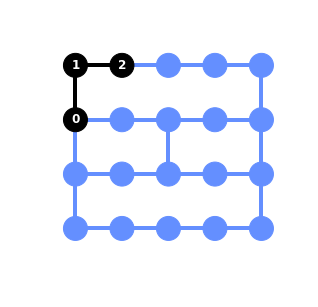

In [16]:
key='ibmq_johannesburg'
backend = provider.get_backend(key)
initial_layout=[5,0,1]
compiled_circuits = transpile(testCircuitlist, backend=backend, initial_layout=initial_layout,optimization_level=3)

plot_circuit_layout(compiled_circuits[0], backend)

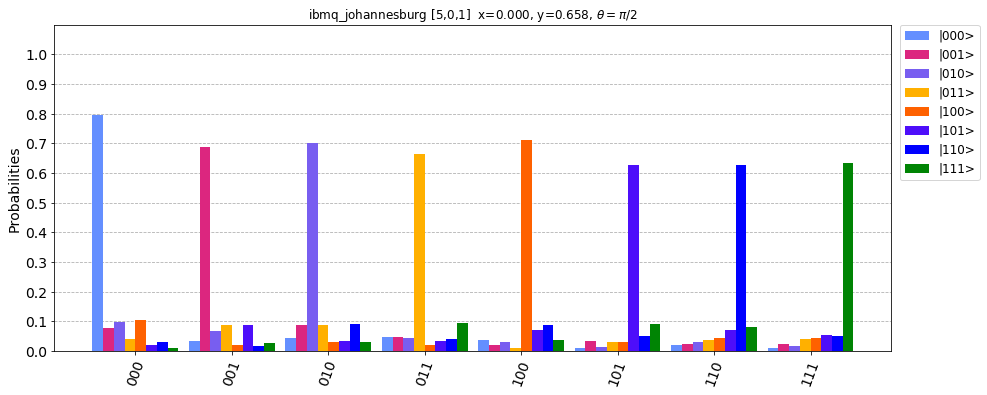

In [17]:
if secure_mode:
    job.update({key:data[key]})
    p=plot_histogram([job[key][i] for i in range(8)],figsize=(15,6),color=color,legend=legend,title=key+' '+qbits[key]+' '+tit,bar_labels=False)
else:
    job.update({key:execute(compiled_circuits,
                backend=backend,
                parameter_binds=[subsprim],shots=8192)})
    p=plot_histogram([job[key].result().get_counts(i) for i in range(8)],figsize=(15,6),color=color,legend=legend,title=key+' '+qbits[key]+' '+tit,bar_labels=False)

p.axes[0].set_yticks([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])
p.axes[0].set_ylim(top=1.1)
p

# ibmq_johannesburg \[11,12,13\]

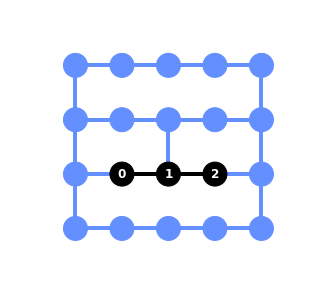

In [18]:
key='ibmq_johannesburg'
backend = provider.get_backend(key)
initial_layout=[11,12,13]
compiled_circuits = transpile(testCircuitlist, backend=backend, initial_layout=initial_layout,optimization_level=3)

plot_circuit_layout(compiled_circuits[0], backend)

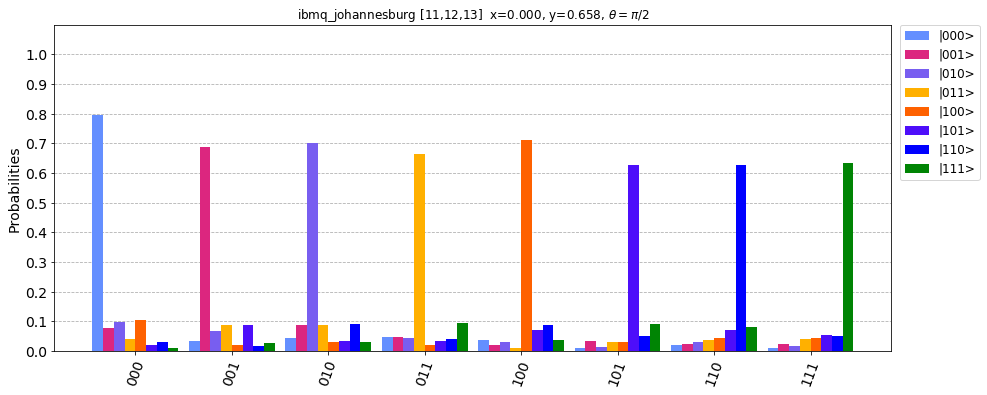

In [19]:
keyaux=key+'_1'
if secure_mode:
    job.update({keyaux:data[keyaux]})
    p=plot_histogram([job[key][i] for i in range(8)],figsize=(15,6),color=color,legend=legend,title=key+' '+qbits[keyaux]+' '+tit,bar_labels=False)
else:
    job.update({keyaux:execute(compiled_circuits,
                backend=backend,
                parameter_binds=[subsprim],shots=8192)})
    p=plot_histogram([job[keyaux].result().get_counts(i) for i in range(8)],figsize=(15,6),color=color,legend=legend,title=key+' '+qbits[key]+' '+tit,bar_labels=False)

p.axes[0].set_yticks([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])
p.axes[0].set_ylim(top=1.1)
p

# Reliability coefficient

Associated to a notion of distance such that

$$ 0\leq d(v_{t},u_{o}^t) \leq 1$$

there is a notion of reliability defined as follows

$$v_{t}=\operatorname{Tr}\left[\left(|{000}><{000}|,\cdots, |{111}><{111}|\right)|{t}><{t}| \right]$$
$$u_{o}^t=\operatorname{Tr}\left[\left(|{000}><{000}|,\cdots, |{111}><{111}|\right)\rho_o^{t} \right]$$


Arises as a coefficient  $r=1-d(v_{t},u_{o}^t)$. In this work three notions of distance will be considered

$$d_{2}(v_{t},u_{o}^t)= \frac{\lVert v_{t}-u_{o}^t\rVert_2}{\sqrt{2}}$$
$$d_{\infty}(v_{t},u_{o}^t)={\lVert v_{t}-u_{o}^t\rVert_\infty}$$
$$d_{h}(v_{t},u_{o}^t)=\sum_{|{i_1i_2i_3}>\in\textrm{C.Basis}}<{i_1i_2i_3}|\rho_o^{t}|{i_1i_2i_3}>d_h(t_1t_2t_3,i_1i_2i_3)$$


In the cell below every notion of distance is implemented


In [20]:
def dinfty(job,shots,initial):
    res=0;
    for q0 in range(2):
        for q1 in range(2):
            for q2 in range(2):
                try:
                    if str(q0)+str(q1)+str(q2)==initial:
                        res=max((1-job[str(q0)+str(q1)+str(q2)]/shots),res)
                    else:
                        res=max((job[str(q0)+str(q1)+str(q2)]/shots),res)
                except:
                    ;
    return res

def din(job,shots,initial,n):
    res=0;
    for q0 in range(2):
        for q1 in range(2):
            for q2 in range(2):
                try:
                    if str(q0)+str(q1)+str(q2)==initial:
                        res=(1-job[str(q0)+str(q1)+str(q2)]/shots)**n+res
                    else:
                        res=(job[str(q0)+str(q1)+str(q2)]/shots)**n+res
                except:
                    if str(q0)+str(q1)+str(q2)==initial:
                        res=1+res
                    ;
    return (res/2)**(1/n)

def distancia(job,n,shots):
    res=0;
    j=0;
    sd=0
    if n == -1:
        for q0 in range(2):
            for q1 in range(2):
                for q2 in range(2):
                    res=max(dinfty(job[j],shots,str(q0)+str(q1)+str(q2)),res)
                    j=j+1
        j=0
        for q0 in range(2):
            for q1 in range(2):
                for q2 in range(2):
                    sd=max(abs(dinfty(job[j],shots,str(q0)+str(q1)+str(q2))-res),sd)
                    j=j+1
    else:
         for q0 in range(2):
            for q1 in range(2):
                for q2 in range(2):
                    res=res+din(job[j],shots,str(q0)+str(q1)+str(q2),n)
                    j=j+1  
         j=0;   
         for q0 in range(2):
            for q1 in range(2):
                for q2 in range(2):
                    sd=sd+(res/8-din(job[j],shots,str(q0)+str(q1)+str(q2),n))**2
                    j=j+1   
         res=(res/8)**(1/n)
         sd=(sd/7)**(1/2)
    return res,sd



from scipy.spatial import distance

def hamming_distancia(job,shots,initial):
    s1=initial
    j=0
    res=0
    for q0 in range(2):
        for q1 in range(2):
            for q2 in range(2):
                s2=str(q0)+str(q1)+str(q2)
                try:
                     res+=distance.hamming([s1[0],s1[1],s1[2]],[s2[0],s2[1],s2[2]])*job[s2]/shots
                except:
                     ;
                j=j+1    
    return res


def dh(job,shots):
    j=0
    res=0
    for q0 in range(2):
        for q1 in range(2):
            for q2 in range(2):
                res=res+hamming_distancia(job[j],shots,str(q0)+str(q1)+str(q2))
                j=j+1;
    sd=0
    j=0
    for q0 in range(2):
        for q1 in range(2):
            for q2 in range(2):
                sd=sd+(res/8-hamming_distancia(job[j],shots,str(q0)+str(q1)+str(q2)))**2
                j=j+1;
    return res/8,np.sqrt(sd/7)



The distance of this particular experiment is computed below

In [21]:
jobcoeff={};

if secure_mode:
    jobcoeff.update(job)
    jobcoeff.update({'qasm_simulator':[jobcoeff['qasm_simulator'].result().get_counts(i) for i in range(8)]})
else:
    for backend in job:
        jobcoeff.update({backend:[job[backend].result().get_counts(i) for i in range(8)]})


norm1=[]
error1=[]
ordenadores=[
 'ibmq_ourense',
 'ibmqx2',
 'ibmq_johannesburg_1',
 'ibmq_johannesburg',
 'qasm_simulator'
 ]

for i in ordenadores:
    a,b=distancia(jobcoeff[i],1,8192)
    norm1.append(1-a)
    error1.append(b)

norm2=[]
error2=[]
for i in ordenadores:
    a,b=distancia(jobcoeff[i],-1,8192)
    norm2.append(1-a)
    error2.append(b)

normh=[]
errorh=[]
for i in ordenadores:
    a,b=dh(jobcoeff[i],8192)
    normh.append(1-a)
    errorh.append(b)
errorh=np.array(errorh)

# Results of the coefficient computation

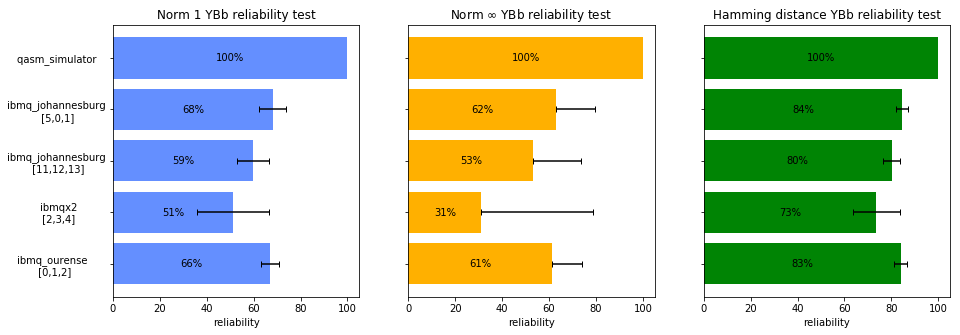

In [22]:
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(131)

patch_handles = []
for i in range(5):
    patch_handles.append(ax.barh(i, 100*norm1[i], align='center', color=color[0]))
    patch = patch_handles[-1][0] 
    bl = patch.get_xy()
    x = 0.5*patch.get_width() + bl[0]
    y = 0.5*patch.get_height() + bl[1]
    ax.text(x, y, "%d%%" % (100*norm1[i]), ha='center',va='center')
    x=patch.get_width() + bl[0]
    if not(i==4):
         l, caps, c=ax.errorbar(x, y, xerr=100*error1[i], color='black', xlolims=True, xuplims=True)#fmt='|',
         for aux in caps: aux.set_marker('|')
y_pos = np.arange(5)
ax.set_yticks(y_pos)


ylabel=[
 'ibmq_ourense      \n [0,1,2]           ',
 'ibmqx2         \n [2,3,4]          ',
 'ibmq_johannesburg\n [11,12,13]       ',
 'ibmq_johannesburg\n [5,0,1]          ',
 'qasm_simulator   '
 ]

ax.set_yticklabels(ylabel)
ax.set_xlabel('reliability')
ax.set_title('Norm 1 YBb reliability test')


ax2 = fig.add_subplot(132)

patch_handles = []
for i in range(5):
    patch_handles.append(ax2.barh(i, 100*norm2[i], align='center', color=color[3]))
    patch = patch_handles[-1][0] 
    bl = patch.get_xy()
    x = 0.5*patch.get_width() + bl[0]
    y = 0.5*patch.get_height() + bl[1]
    ax2.text(x, y, "%d%%" % (100*norm2[i]), ha='center',va='center')
    x=patch.get_width() + bl[0]
    if not(i==4):
        l, caps, c=ax2.errorbar(x, y, xerr=[[0],[100*error2[i]]], color='black', xlolims=True, xuplims=True)#fmt='|',
        for aux in caps: aux.set_marker('|')
y_pos = np.arange(5)
ax2.set_yticks(y_pos)
ax2.set_yticklabels(['','','','',''])
ax2.set_xlabel('reliability')
ax2.set_title('Norm $\infty$ YBb reliability test')
fig.show()



ax3 = fig.add_subplot(133)

patch_handles = []
for i in range(5):
    patch_handles.append(ax3.barh(i, 100*normh[i], align='center', color=color[7]))
    patch = patch_handles[-1][0] 
    bl = patch.get_xy()
    x = 0.5*patch.get_width() + bl[0]
    y = 0.5*patch.get_height() + bl[1]
    ax3.text(x, y, "%d%%" % (100*normh[i]), ha='center',va='center')
    x=patch.get_width() + bl[0]
    if not(i==4):
        l, caps, c=ax3.errorbar(x, y, xerr=100*errorh[i], color='black', xlolims=True, xuplims=True)#fmt='|',
        for aux in caps: aux.set_marker('|')
y_pos = np.arange(5)
ax3.set_yticks(y_pos)
ax3.set_yticklabels(['','','','',''])
ax3.set_xlabel('reliability')
ax3.set_title('Hamming distance YBb reliability test')

fig.show()

# Saving the data

In [23]:
import pickle
import datetime
def save(x1,x2,theta,jobExt,legend):
    job={}
    job.update({'legend': legend})
    job.update({'parameters':{'x':x1,'y':x2,'theta':theta}})
    job.update({'results':[jobExt.result().get_counts(i) for i in range(8)]})

    date = datetime.datetime.now()

    now=str(date.day)+'_'+str(date.month)+'_'+str(date.year)+'_'+str(date.hour)+'_'+str(date.minute)

    f = open("experiments/ConsisitencyBraided"+now+".pkl","wb")
    pickle.dump(job,f)
    f.close()

In [24]:
if not secure_mode:
    save(x1,x2,theta,job,legend)